In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data Downloading

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d carlthome/gtzan-genre-collection


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
!unzip gtzan-genre-collection.zip -d data/


unzip:  cannot find or open gtzan-genre-collection.zip, gtzan-genre-collection.zip.zip or gtzan-genre-collection.zip.ZIP.


In [ ]:
data_dir = '/content/drive/MyDrive/data/genres'

In [ ]:
classes = os.listdir(data_dir)

In [ ]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

# Data Visualization

22050


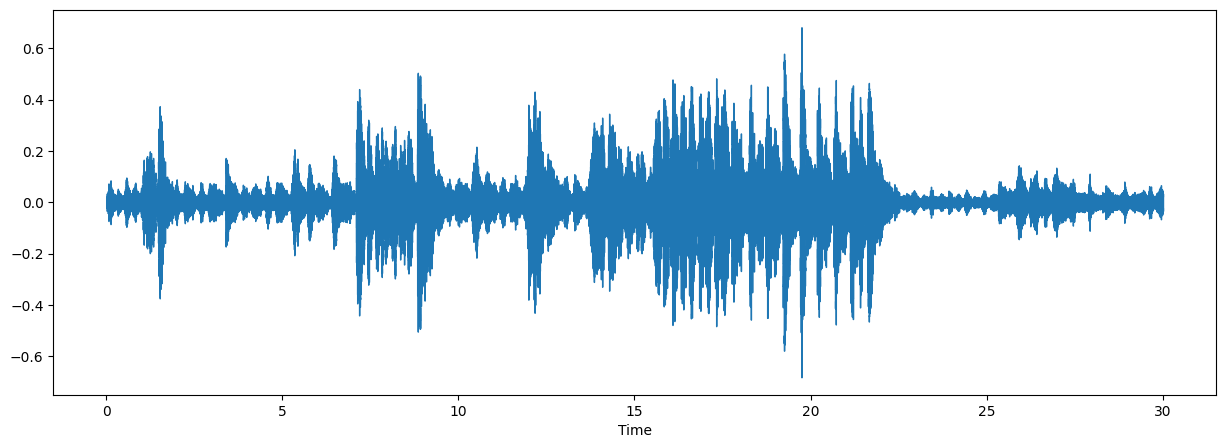

In [ ]:
file_path = '/content/drive/MyDrive/data/genres/jazz/jazz.00000.au'
y,sr = librosa.load(file_path,sr = None)
plt.figure(figsize = (15,5))
librosa.display.waveshow(y = y,sr = sr)
print(sr)
plt.show()

(128, 1293)


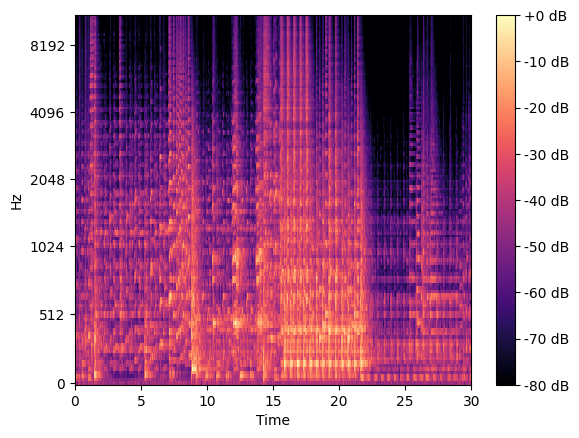

In [ ]:
spectrogram = librosa.feature.melspectrogram(y=y,sr = sr)
spectrogram= librosa.power_to_db(spectrogram,ref = np.max)
librosa.display.specshow(spectrogram,sr = sr,x_axis = 'time',y_axis = 'mel')
print(spectrogram.shape)
plt.colorbar(format = '%+2.0f dB')
plt.show()

In [ ]:
segment_length = 4
overlap = 2
sample_per_segment = 4 * sr
step = (segment_length - overlap) * sr
segments = []
for star in range(0,len(y)-sample_per_segment+1,int(step)):
  segment = y[star:star+int(sample_per_segment)]
  segments.append(segment)

In [ ]:
len(segments)

14

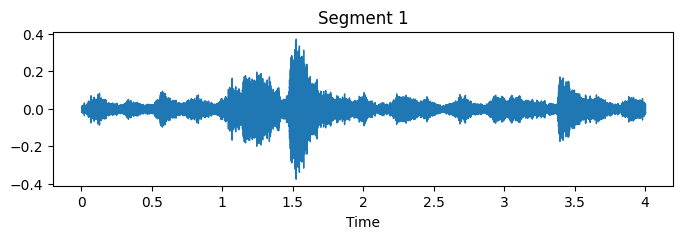

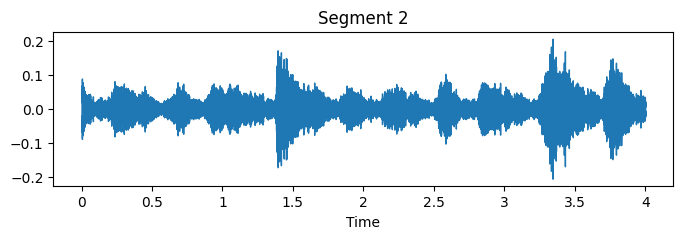

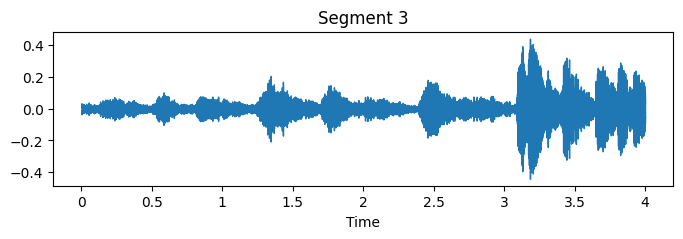

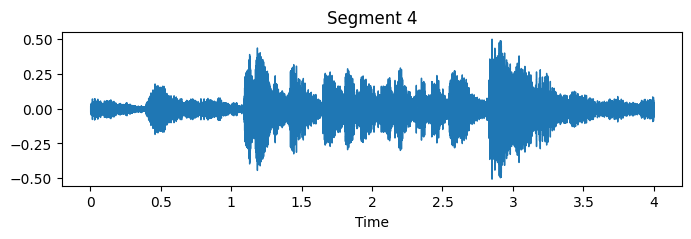

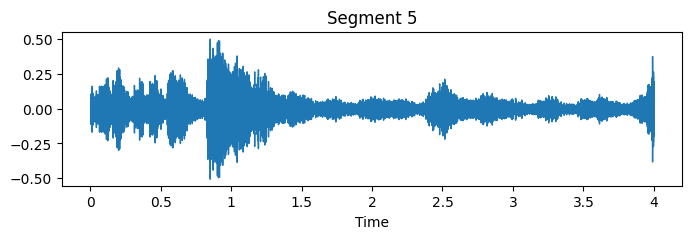

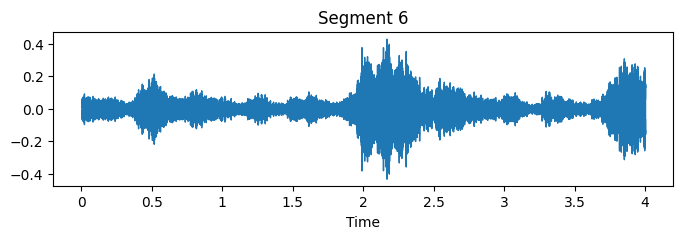

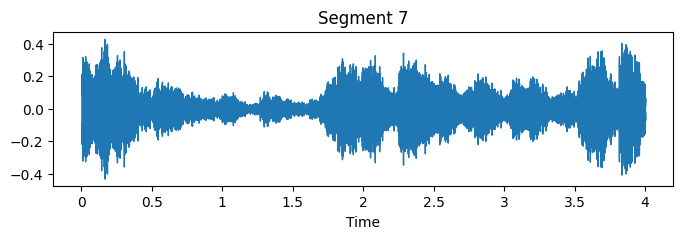

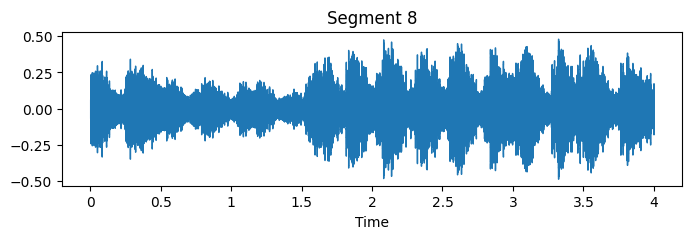

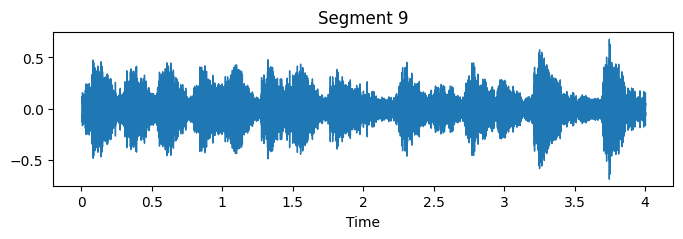

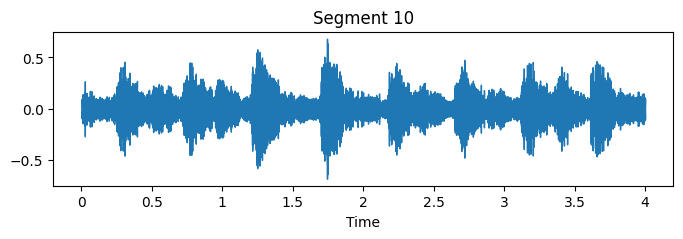

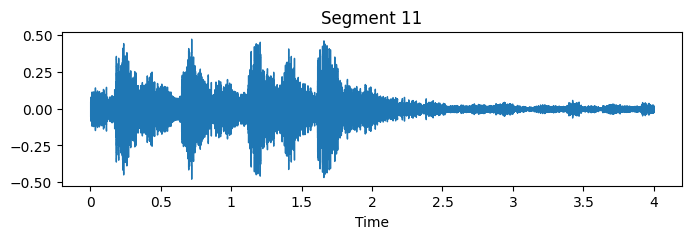

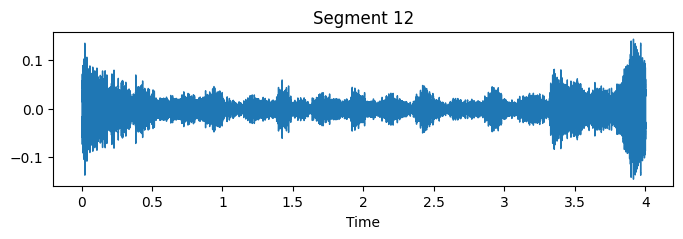

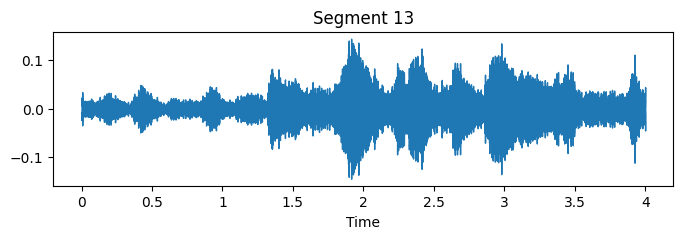

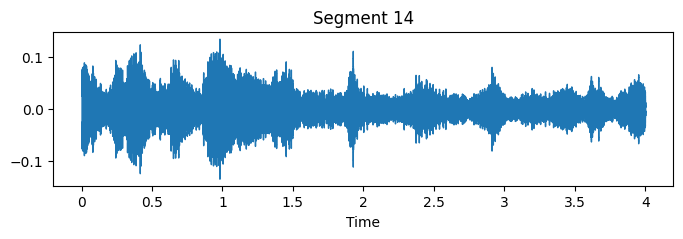

In [ ]:

for i, segment in enumerate(segments):
    plt.figure(figsize=(8, 2))
    librosa.display.waveshow(y=segment, sr=sr)
    plt.title(f"Segment {i+1}")
    plt.show()

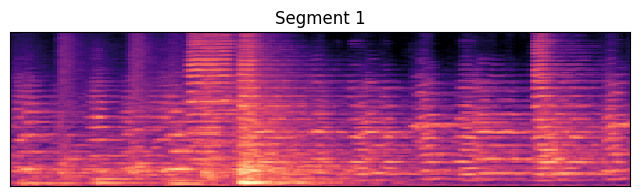

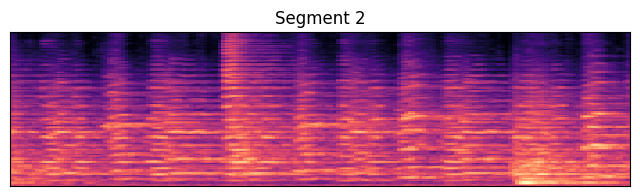

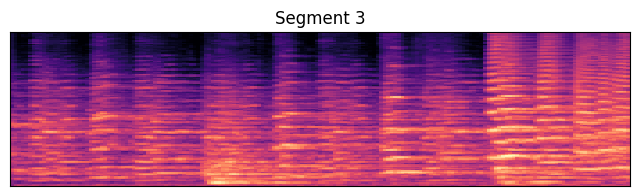

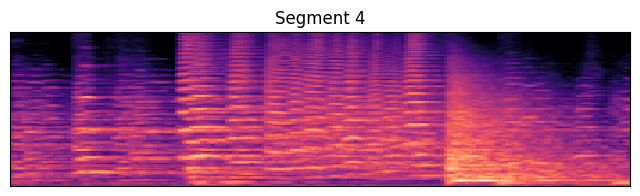

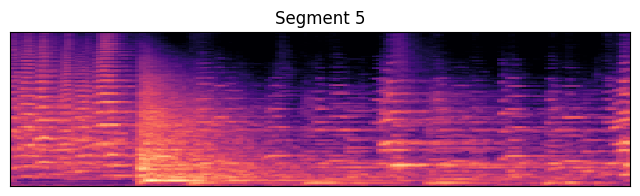

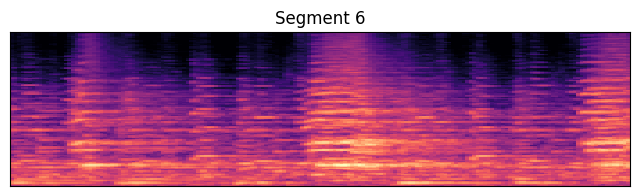

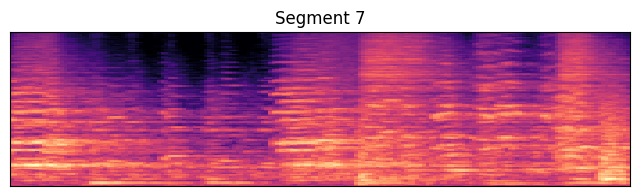

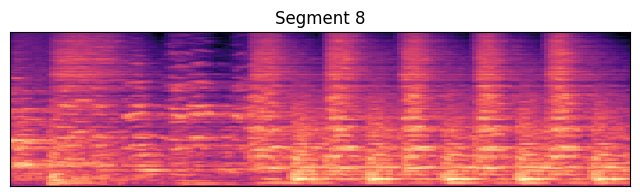

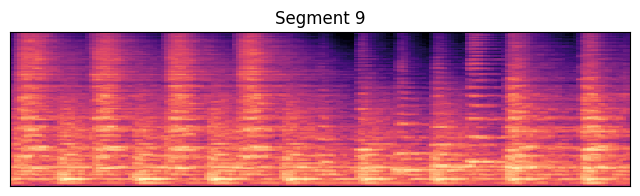

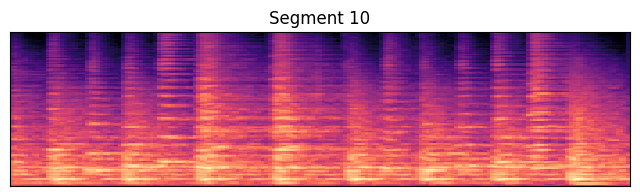

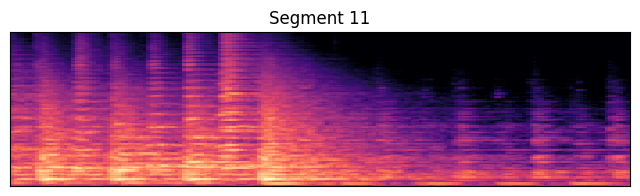

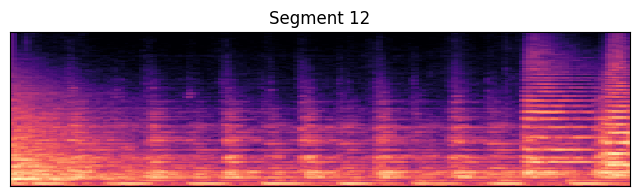

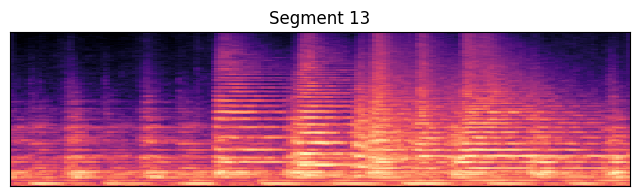

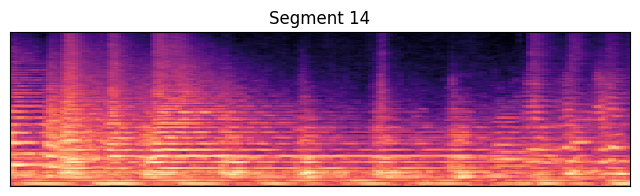

In [ ]:
for i, segment in enumerate(segments):
    plt.figure(figsize=(8, 2))
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram,ref = np.max)
    librosa.display.specshow(spectrogram, sr=sr)
    plt.title(f"Segment {i+1}")
    plt.show()

# Data preprocessing

In [ ]:
data = []

for genre in os.listdir(data_dir):
  genre_path = os.path.join(data_dir,genre)
  for file in os.listdir(genre_path):
    if file.endswith('.au'):
      file_path = os.path.join(genre_path,file)
      data.append((genre,file_path))

In [ ]:
import pandas as pd
df = pd.DataFrame(data,columns = ['genre','file_path'])

In [ ]:
df.head()

,genre,file_path
0,blues,/content/drive/MyDrive/data/genres/blues/blues...
1,blues,/content/drive/MyDrive/data/genres/blues/blues...
2,blues,/content/drive/MyDrive/data/genres/blues/blues...
3,blues,/content/drive/MyDrive/data/genres/blues/blues...
4,blues,/content/drive/MyDrive/data/genres/blues/blues...


In [ ]:
df.shape

(1000, 2)

In [ ]:
import soundfile as sf
from tqdm import tqdm

In [ ]:
segment_length = 4  # seconds
overlap = 2         # seconds
sr = 22050          # sample rate (same for all)
output_dir = "/content/drive/MyDrive/segmented_data_2"

os.makedirs(output_dir, exist_ok=True)

In [ ]:
segmented_data = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    label = row['genre']
    path = row['file_path']

    # Load the audio (limit to 30 sec if needed)
    y, sr = librosa.load(path, sr=sr, duration=30)

    # Compute number of samples per segment and step size
    samples_per_segment = int(segment_length * sr)
    step = int((segment_length - overlap) * sr)

    # Make label folder inside output directory
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Loop through segments
    for start in range(0, len(y) - samples_per_segment + 1, step):
        segment = y[start:start + samples_per_segment]
        seg_name = f"{os.path.splitext(os.path.basename(path))[0]}_{start}.wav"
        seg_path = os.path.join(label_dir, seg_name)

        # Save each chunk as a new wav file
        sf.write(seg_path, segment, sr)

        # Store label and path
        segmented_data.append((label, seg_path))

# Convert to new DataFrame
seg_df = pd.DataFrame(segmented_data, columns=['label', 'path'])
print(seg_df.head(), len(seg_df))


100%|██████████| 1000/1000 [13:58<00:00,  1.19it/s]

   label                                               path
0  blues  /content/drive/MyDrive/segmented_data_2/blues/...
1  blues  /content/drive/MyDrive/segmented_data_2/blues/...
2  blues  /content/drive/MyDrive/segmented_data_2/blues/...
3  blues  /content/drive/MyDrive/segmented_data_2/blues/...
4  blues  /content/drive/MyDrive/segmented_data_2/blues/... 13991


In [ ]:
seg_df.head()

,label,path
0,blues,/content/drive/MyDrive/segmented_data_2/blues/...
1,blues,/content/drive/MyDrive/segmented_data_2/blues/...
2,blues,/content/drive/MyDrive/segmented_data_2/blues/...
3,blues,/content/drive/MyDrive/segmented_data_2/blues/...
4,blues,/content/drive/MyDrive/segmented_data_2/blues/...


In [ ]:
seg_df.shape

(13991, 2)

In [ ]:
seg_df['label'].value_counts()

,count
label,
blues,1400
jazz,1400
pop,1400
reggae,1400
metal,1400
disco,1399
rock,1399
classical,1398
hiphop,1398


In [ ]:
# again loading the data from directory i saved earlier because i lost the session

# import os
# import pandas as pd

# # Directory where segmented files are saved
# segmented_dir = '/content/drive/MyDrive/segmented_data'

# data = []

# # Loop through each genre folder
# for genre in os.listdir(segmented_dir):
#     genre_path = os.path.join(segmented_dir, genre)

#     if os.path.isdir(genre_path):  # check it's a folder
#         for file in os.listdir(genre_path):
#             if file.endswith('.wav') or file.endswith('.au'):  # check file type
#                 file_path = os.path.join(genre_path, file)
#                 data.append((genre, file_path))

# # Create DataFrame
# seg_df = pd.DataFrame(data, columns=['label', 'path'])
# print(seg_df.head())
# print(f"Total samples: {len(seg_df)}")


     label                                               path
0  country  /content/drive/MyDrive/segmented_data/country/...
1  country  /content/drive/MyDrive/segmented_data/country/...
2  country  /content/drive/MyDrive/segmented_data/country/...
3  country  /content/drive/MyDrive/segmented_data/country/...
4  country  /content/drive/MyDrive/segmented_data/country/...
Total samples: 13991


In [ ]:
seg_df.shape

(13991, 2)

In [ ]:
# Parameters
sr = 22050                # Sample rate (same as used before)
n_fft = 2048              # FFT window size
hop_length = 512          # Step between successive frames
n_mels = 128              # Number of Mel bands
duration = 4              # Each segment is 4s
samples_per_track = sr * duration

In [ ]:
def extract_mel_spectrogram(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    # Load the audio
    y, sr = librosa.load(file_path, sr=sr)

    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )

    # Convert power (amplitude squared) to decibels (log scale)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mel_spec_db


In [ ]:
from tqdm.notebook import tqdm
mel_spectrograms = []
labels = []

for idx, row in tqdm(seg_df.iterrows(), total=len(seg_df)):
    file_path = row['path']
    label = row['label']

    try:
        mel_spec = extract_mel_spectrogram(file_path)
        mel_spectrograms.append(mel_spec)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")


  0%|          | 0/13991 [00:00<?, ?it/s]

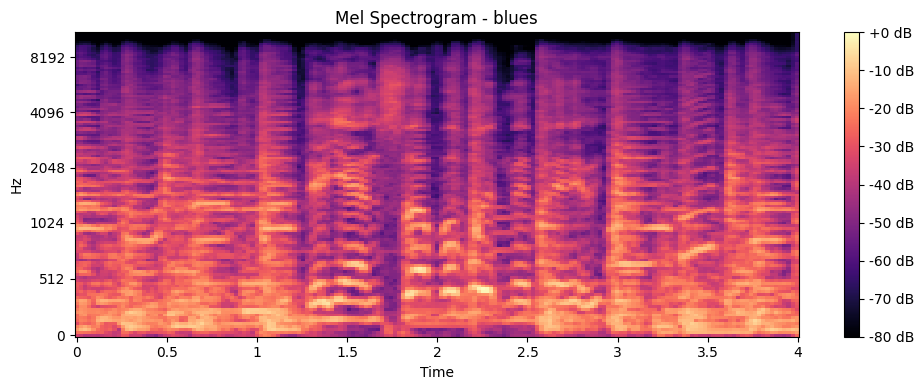

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrograms[0], sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram - {labels[0]}")
plt.tight_layout()
plt.show()


In [ ]:
# convert to numpy array
X = np.array(mel_spectrograms)
y = np.array(labels)
print(X.shape, y.shape)


(13991, 128, 173) (13991,)


In [ ]:
# save for later use
np.save('X_mel_genre.npy', X)
np.save('y_mel_genre.npy', y)

In [ ]:
X = tf.convert_to_tensor(X, dtype=tf.float32)
print("Original shape:", X.shape)

Original shape: (13991, 128, 173)


In [ ]:
X = tf.expand_dims(X, axis=-1)  # now (13991, 128, 173, 1)
print("After adding channel:", X.shape)

After adding channel: (13991, 128, 173, 1)


In [ ]:
target_height = 150
target_width = 150

X_resized = tf.image.resize(X, [target_height, target_width], method='bilinear')
print("After resizing:", X_resized.shape)

After resizing: (13991, 150, 150, 1)


In [ ]:
X_min = tf.reduce_min(X_resized)
X_max = tf.reduce_max(X_resized)
X_norm = (X_resized - X_min) / (X_max - X_min)

In [ ]:
X_final = X_norm.numpy()
print(X_final.shape)

(13991, 150, 150, 1)


In [ ]:
y

array(['blues', 'blues', 'blues', ..., 'rock', 'rock', 'rock'],
      dtype='<U9')

In [ ]:
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

In [ ]:
y_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_categorical, stratify=y_categorical, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (11192, 150, 150, 1)
X_test shape: (2799, 150, 150, 1)
y_train shape: (11192, 10)
y_test shape: (2799, 10)


In [ ]:
from tensorflow.keras import layers, models
def build_cnn(input_shape=(150,150,1), num_classes=10):
    model = models.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        # 1️⃣ Conv Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        # 2️⃣ Conv Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # 3️⃣ Conv Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # 4️⃣ Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ ?                      │   0 (unbuilt) │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Metric to monitor
    factor=0.5,              # Reduce LR by half
    patience=3,              # Wait 3 epochs without improvement
    min_lr=1e-6,             # Do not go below this
    verbose=1
)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=
        reduce_lr
)


Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.7708 - loss: 0.6840 - val_accuracy: 0.7749 - val_loss: 0.6399 - learning_rate: 2.5000e-04
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.7735 - loss: 0.6630 - val_accuracy: 0.7785 - val_loss: 0.7546 - learning_rate: 2.5000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.7890 - loss: 0.6205 - val_accuracy: 0.7713 - val_loss: 0.6885 - learning_rate: 2.5000e-04
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8025 - loss: 0.5946
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.8025 - loss: 0.5946 - val_accuracy: 0.7692 - val_loss: 0.8176 - learning_rate: 2.5000e-04
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.8080 - loss: 0.5741 - val_accuracy: 0.7867 - val_loss: 0.6558 - learning_rate: 1.2500e-04
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - ac

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7444 - loss: 1.2029
Test Accuracy: 0.7370


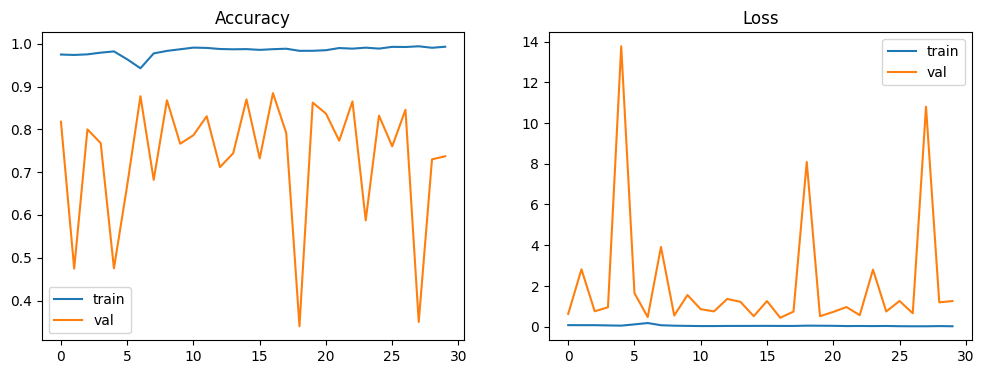

In [ ]:

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.legend()

plt.show()


In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf

def load_and_preprocess_data(data_dir, classes, target_shape=(150,150)):
    data = []
    labels = []

    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print(f"Processing class: {class_name}")

        for file in os.listdir(class_dir):
            if file.endswith(('.wav', '.au')):  # ✅ fixed here
                file_path = os.path.join(class_dir, file)
                y, sr = librosa.load(file_path, sr=None)

                # Chunking parameters
                chunk_duration = 4
                overlap = 2
                chunk_samples = chunk_duration * sr
                overlap_samples = overlap * sr

                # Pad short clips
                if len(y) < chunk_samples:
                    y = np.pad(y, (0, chunk_samples - len(y)))

                # Calculate number of chunks
                num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = y[start:end]
                    if len(chunk) < chunk_samples:
                        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

                    # Compute mel spectrogram
                    spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
                    spectrogram = tf.image.resize(tf.expand_dims(spectrogram, axis=-1), target_shape)
                    data.append(spectrogram.numpy())
                    labels.append(i_class)

    print(f"✅ Total samples created: {len(data)}")
    return np.array(data), np.array(labels)


In [5]:
data_dir = '/content/drive/MyDrive/data/genres'
classes = os.listdir(data_dir)
X, y = load_and_preprocess_data(data_dir, classes)
print(X.shape, y.shape)

Processing class: blues
Processing class: classical
Processing class: country
Processing class: disco
Processing class: hiphop
Processing class: jazz
Processing class: metal
Processing class: pop
Processing class: reggae
Processing class: rock
✅ Total samples created: 14990
(14990, 150, 150, 1) (14990,)


In [6]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y,num_classes = len(classes))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state =42)

In [8]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Block 1
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(150,150,1)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),


    # Dense Head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 23,571,402 (89.92 MB)

 Trainable params: 23,567,562 (89.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # lower LR for deeper nets
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=50,                   # train longer now
    batch_size=32,
    validation_data=(X_test, y_test))


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 273ms/step - accuracy: 0.2745 - loss: 2.4623 - val_accuracy: 0.1795 - val_loss: 5.0297
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.5058 - loss: 1.5222 - val_accuracy: 0.3853 - val_loss: 3.3776
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.6197 - loss: 1.1573 - val_accuracy: 0.4823 - val_loss: 2.6817
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.6892 - loss: 0.9450 - val_accuracy: 0.4987 - val_loss: 2.1164
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.7327 - loss: 0.8237 - val_accuracy: 0.5384 - val_loss: 1.8994
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.7584 - loss: 0.7383 - val_accuracy: 0.5150 - val_loss: 4.3510
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.7892 - loss: 0.6239 - val_accuracy: 0.4206 - val_loss: 4.0635
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 190ms/step - accuracy: 0.8175 - loss: 

In [ ]:
x = 10